## Tacotron 2 inference code 
Edit the variables **checkpoint_path** and **text** to match yours and run the entire code to generate plots of mel outputs, alignments and audio synthesis from the generated mel-spectrogram using Griffin-Lim.

#### Import libraries and setup matplotlib

In [1]:
import matplotlib
import matplotlib.pyplot as plt

import IPython.display as ipd

import sys
sys.path.append('/home/gyzhang/projects/waveglow/')
import numpy as np
import torch
import json

from hparams import create_hparams
from model import Tacotron2
from layers import TacotronSTFT, STFT
from audio_processing import griffin_lim
from train import load_model
from text import text_to_sequence,cmudict, candict, sequence_to_text
from denoiser import Denoiser

from data_utils import TextMelLoader, TextMelCollate
from hparams import create_hparams
from torch.utils.data import DataLoader
from glow import WaveGlow

/home/gyzhang/projects/tacotron2/plotting_utils.py:2: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/home/gyzhang/anaconda3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/gyzhang/anaconda3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/gyzhang/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/gyzhang/anaconda3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/gyzhang/anaconda3/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 499, in start
    self.io_loop.s

In [2]:
def plot_data(data, figsize=(16, 4)):
    fig, axes = plt.subplots(1, len(data), figsize=figsize)
    for i in range(len(data)):
        axes[i].imshow(data[i], aspect='auto', origin='bottom', 
                       interpolation='none')

#### Setup hparams

In [3]:
hparams = create_hparams()
hparams.sampling_rate = 16000


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



#### Load model from checkpoint

In [4]:
checkpoint_path = "./outdir10/checkpoint_66500"
model = load_model(hparams)
model.load_state_dict(torch.load(checkpoint_path)['state_dict'])
_ = model.cuda().eval().half()

#### Load WaveGlow for mel2audio synthesis and denoiser

In [5]:
with open('/home/gyzhang/projects/waveglow/config.json') as f:
    data = f.read()
config = json.loads(data)
waveglow_config = config["waveglow_config"]
waveglow = WaveGlow(**waveglow_config)
waveglow_path = '/home/gyzhang/projects/waveglow/waveglow_4000'
waveglow_ck = torch.load(waveglow_path)['model']
waveglow.load_state_dict(waveglow_ck.state_dict())
# waveglow_path = './waveglow/waveglow_256channels_new.pt'
# waveglow = torch.load(waveglow_path)['model']
waveglow.cuda().eval().half()
for k in waveglow.convinv:
    k.float()
denoiser = Denoiser(waveglow)

/home/gyzhang/anaconda3/lib/python3.6/site-packages/torch/serialization.py:435: SourceChangeWarning: source code of class 'torch.nn.modules.conv.ConvTranspose1d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/home/gyzhang/anaconda3/lib/python3.6/site-packages/torch/serialization.py:435: SourceChangeWarning: source code of class 'torch.nn.modules.container.ModuleList' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/home/gyzhang/anaconda3/lib/python3.6/site-packages/torch/serialization.py:435: SourceChangeWarning: source code of class 'torch.nn.modules.conv.Conv1d' has changed. you can retrieve the original source code by acc

#### Prepare text input

In [15]:
text = "hek3-hot3-ceng2-haak3-bat1-jing1-tai4-coeng1"
sequence = np.array(text_to_sequence(text, ['cantonese_cleaners'],candict.Candict().candict))[None, :]
sequence = torch.autograd.Variable(
    torch.from_numpy(sequence)).cuda().long()
spk_ids = torch.LongTensor([11]).cuda()

#### Decode text input and plot results

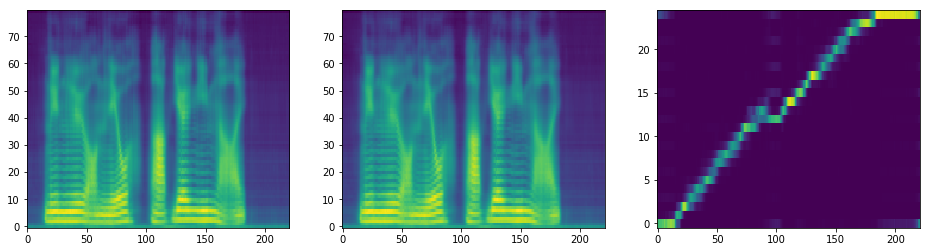

In [16]:
mel_outputs, mel_outputs_postnet, _, alignments = model.inference(sequence, spk_ids)
plot_data((mel_outputs.float().data.cpu().numpy()[0],
           mel_outputs_postnet.float().data.cpu().numpy()[0],
           alignments.float().data.cpu().numpy()[0].T))

#### Synthesize audio from spectrogram using WaveGlow

In [8]:
alignment_result = alignments.float().data.cpu().numpy()[0].T

In [ ]:
fig, ax = plt.subplots(figsize=(25, 12))
im = ax.imshow(alignments.float().data.cpu().numpy()[0].T, aspect='auto', origin='lower',
                   interpolation='none')
text_list = sequence_to_text(sequence[0].cpu().numpy())
ax.set_yticks(np.arange(len(text_list)))
ax.set_yticklabels(text_list, fontdict={'fontsize':10})
ax.set_xticks(np.arange(alignment_result.shape[1], step=2))
ax.set_xticklabels(np.arange(alignment_result.shape[1],step=2)*0.0125, fontdict={'fontsize':7})
# fig.colorbar(im, ax=ax)
xlabel = 'Decoder timestep'
ax.set_xlabel(xlabel)

#### Synthesize audio from spectrogram using WaveGlow

In [17]:
with torch.no_grad():
    audio = waveglow.infer(mel_outputs_postnet, sigma=0.666)
ipd.Audio(audio[0].data.cpu().numpy(), rate=hparams.sampling_rate)

In [ ]:
ipd.Audio("/home/gyzhang/speech_database/CUSENT/CUSENT_wav/newtrain/cn36f/838.wav")

#### (Optional) Remove WaveGlow bias

In [ ]:
audio_denoised = denoiser(audio, strength=0.01)[:, 0]
ipd.Audio(audio_denoised.cpu().numpy(), rate=hparams.sampling_rate) 